In [58]:
import cv2
import os
from commonfunctions import *

In [59]:
def crop_image(image, box):
    x, y, w, h = cv2.boundingRect(box)
    if w < h:
        w, h = h, w
    return image[y:y + h, x:x + w]

In [60]:
def extract_boundaries(image):
    # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Use the Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    return edges

def fill_small_holes(image, kernel_size=3):
    # Read the image
    image = extract_boundaries(image)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Define a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Perform closing to fill small holes
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Perform erosion
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)

    return eroded_edges

In [61]:
def auto_rotate_image(image, counter=1):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and aid contour detection
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_with_contour = image.copy()

    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)

    # Fit a rotated bounding box to the contour
    rect = cv2.minAreaRect(max_contour)

    # Unpack the rectangle information
    (center, (width_contour, height_contour), angle) = rect

    # Ensure width is always the larger side
    if width_contour < height_contour:
        width_contour, height_contour = height_contour, width_contour
        angle -= 90

    height, width = image.shape[:2]
    width_ratio = float(width_contour / width)

    #Counter is for the second call of this function, in this call I am interested in getting the new coordinates of the bounding box but no further rotation needed.
    if counter == 0 and width_ratio > 0.65:

        # Rotate the image to the detected angle
        rotated_image = rotating_image(image_with_contour, angle)
    else:
        return image_with_contour, max_contour

    return rotated_image, max_contour

def rotating_image(image, angle):
    # Get the image dimensions
    height, width = image.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

    # Determine the new bounding box after rotation
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])

    new_width = int((width * cos_theta) + (height * sin_theta))
    new_height = int((width * sin_theta) + (height * cos_theta))

    # Adjust the rotation matrix for translation to keep the entire rotated image
    rotation_matrix[0, 2] += (new_width - width) / 2
    rotation_matrix[1, 2] += (new_height - height) / 2

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height),
                                    borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_image

In [62]:
#Test function

def Background_Removal():
    images_folder = 'SAR_Background/'
    images = os.listdir(images_folder)

    for image in images:
        img_path = os.path.join(images_folder, image)
        img = cv2.imread(img_path)
        if img is not None:
            new_image, contour1 = auto_rotate_image(img, 0)

            rect1 = cv2.minAreaRect(contour1)
            box1 = cv2.boxPoints(rect1)
            box1 = np.int0(box1)

            # Unpack the rectangle information
            (center1, (width_contour1, height_contour1), angle1) = rect1

            # Ensure width is always the larger side
            if width_contour1 < height_contour1:
                width_contour1, height_contour1 = height_contour1, width_contour1
                angle1 -= 90

            rotated_image, contour2 = auto_rotate_image(new_image)
            rect2 = cv2.minAreaRect(contour2)
            box2 = cv2.boxPoints(rect2)

            (center2, (width_contour2, height_contour2), angle2) = rect2

            # Ensure width is always the larger side
            if width_contour2 < height_contour2:
                width_contour2, height_contour2 = height_contour2, width_contour2
                angle2 -= 90

            if -1 < angle2 < 1 and height_contour2 > 50:
                cropped_image = crop_image(rotated_image, box2)
            elif -1 < angle1 < 1 and height_contour1 > 50:
                new_height, new_width = rotated_image.shape[:2]
                # Resize the image
                resized_image = cv2.resize(new_image, (new_width, new_height))
                cropped_image = crop_image(resized_image, box1)     
            else:
                cropped_image = rotated_image

            show_images([cropped_image, rotated_image, new_image, img],['cropped','rotated','New_image','before'])

        else:
            print(f"Cannot open {image}")


C:\Users\Khaled\AppData\Local\Temp\ipykernel_10024\11811715.py:15: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box1 = np.int0(box1)


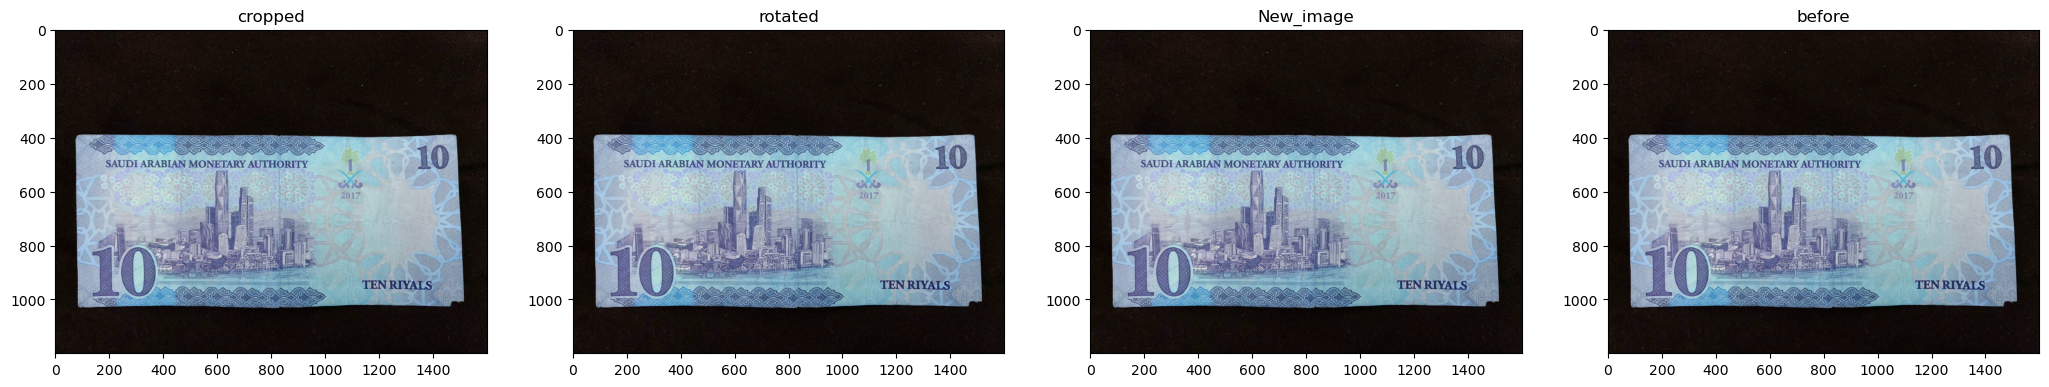

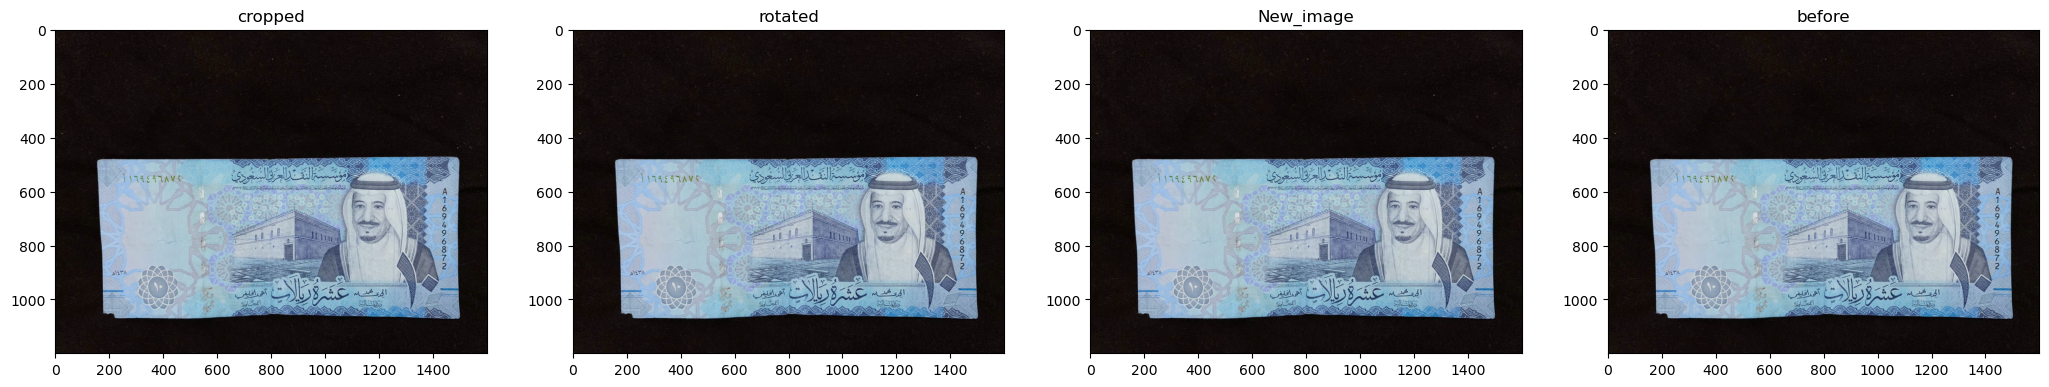

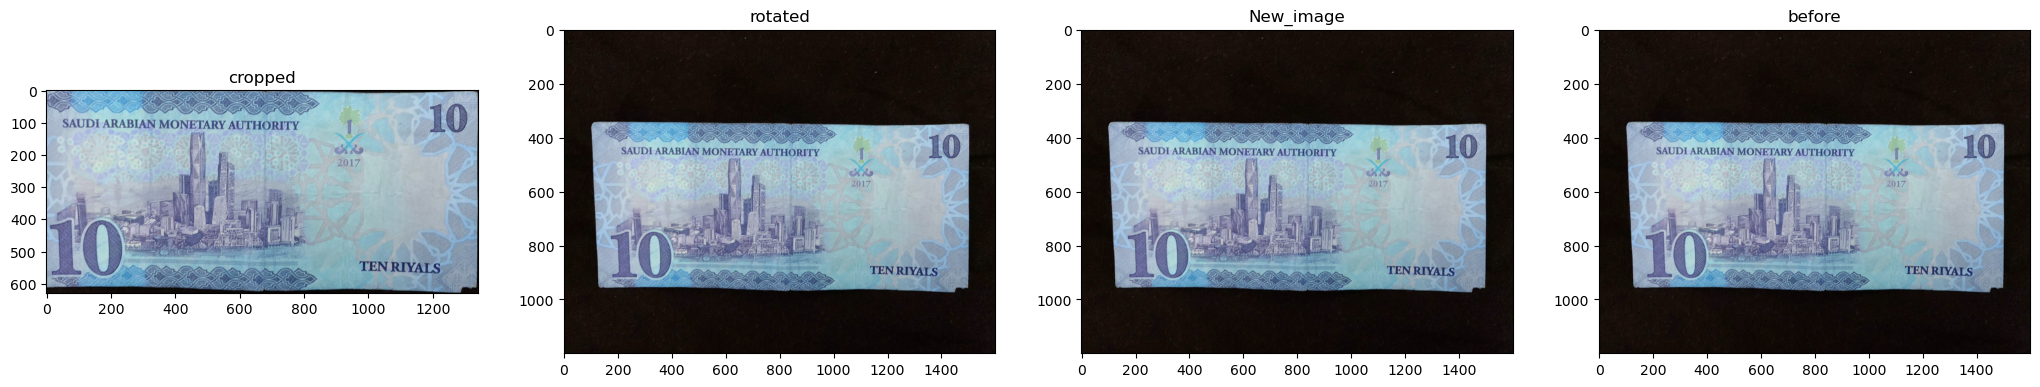

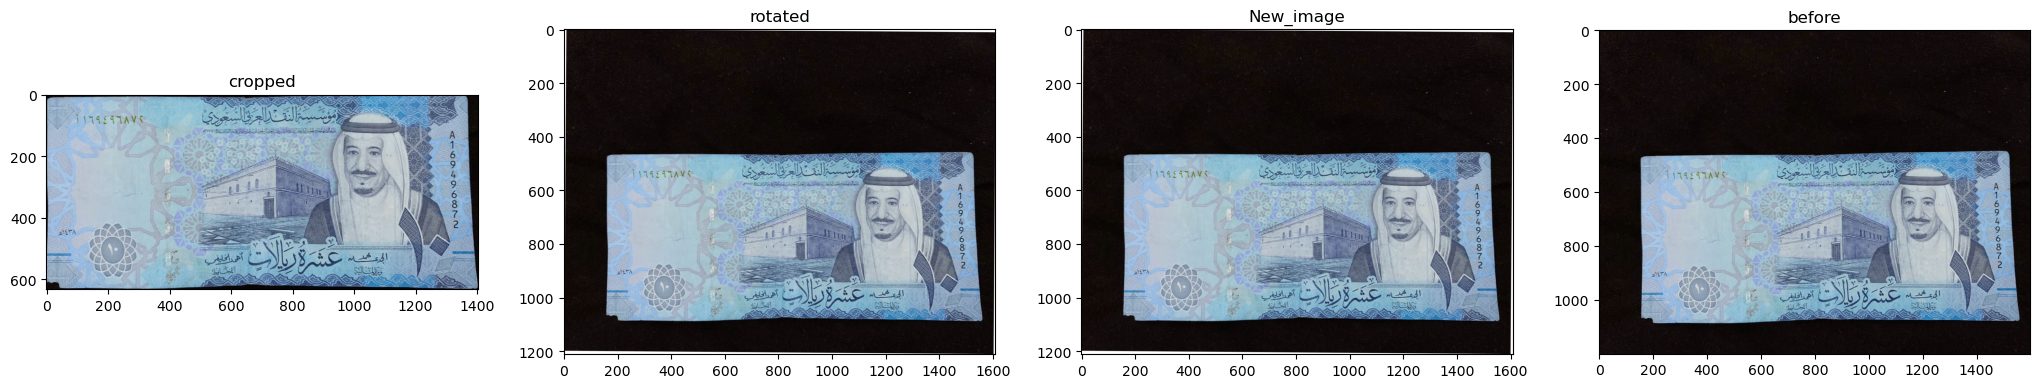

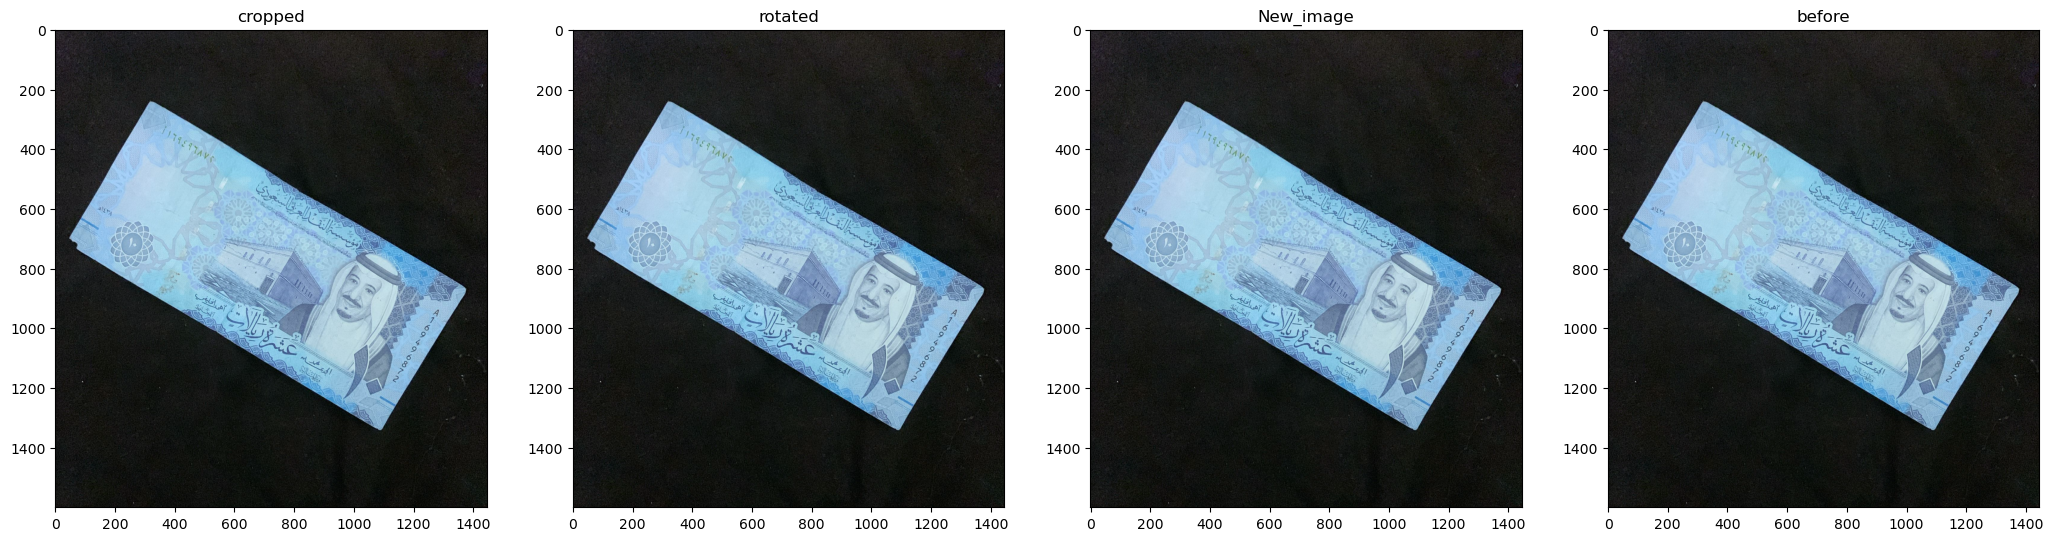

KeyboardInterrupt: 

In [63]:
Background_Removal()